In [1]:
import os
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from matplotlib.gridspec import GridSpec
from scipy.io import loadmat
from scipy.stats import wilcoxon, friedmanchisquare


%matplotlib widget


# Define a function to bin the data during a window
# def count_spikes_in_time_bins(spike_times, total_window_start_end, time_bin_width):

#     num_time_bins = int((total_window_start_end[1]-total_window_start_end[0])/time_bin_width)
#     spikes_counts = np.zeros((num_time_bins,), dtype=int)
#     for spike_time in spike_times:
#         bin_index = int(spike_time/time_bin_width)
#         spikes_counts[bin_index] += 1 



data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'
state_detection_dir =  r'/home/kouroshmaboudi/Documents/NCMLproject/StateDetectionResults/'

sessions = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

included_session_IDX = [x for x in range(17) if x not in (5, 12, 13)]
included_session_IDX.append(5)
# included_session_IDX = [8]

sessions = [sessions[i] for i in included_session_IDX]

session_name_mapping = {'Achilles_10252013': 'Rat A linear',
                        'Achilles_11012013': 'Rat A circular',
                        'Buddy_06272013': 'Rat B',
                        'Cicero_09172014': 'Rat C',
                        'Gatsby_08282013':'Rat G',
                        'RatN_Day2_2019-10-11_03-58-54': 'Rat N',
                        'RatS-Day2-2020-11-27_10-22-29': 'Rat S',
                        'RatU_Day2NSD_2021-07-24_08-16-38': 'Rat U',
                        'RatV_Day1NSD_2021-10-02_08-10-23': 'Rat V linear',
                        'RatV_Day3NSD_2021-10-07_08-10-12': 'Rat V semicircular',
                        'Roy-maze1': 'Rat R',
                        'Ted-maze1': 'Rat T linear',
                        'Ted-maze2': 'Rat T L shape',
                        'Ted-maze3': 'Rat T U shape',
                        'Kevin-maze1': 'Rat K'}

firing_bin_counts_data = []

for session_idx, session_name in enumerate(sessions):

    print(session_name)

    session_dataset_path = os.path.join(data_dir, session_name)
    session_number = included_session_IDX[session_idx]

    #--------------------------------------------------------------------------------------------
    # Load epochs information

    filename = f'{session_name}.fileInfo_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)
    session_info = mat_file["fileInfo"]

    epochs = session_info["behavior"][0][0][0][0]["time"]
    epoch_durations = epochs[:, 1] - epochs[:, 0]


    #---------------------------------------------------------------------------------------------
    # Brain state detection results

    if 0<=session_number<=4 or 6<=session_number<=10:
        filename = f'{session_name}.brainStateDetection_HMMtheta_EMG_SWS_SchmidtTrigger.mat'
        file_path = os.path.join(session_dataset_path, filename)

        mat_file = scipy.io.loadmat(file_path)
        brainStates_bouts_label = mat_file['brainState']['bouts'][0][0][:, :-1]
        bouts_start_end = brainStates_bouts_label[:, :-1]
        bout_labels = brainStates_bouts_label[:, -1].astype(int)

        brainStates_names = []
        for i in range(4):
            brainStates_names.append(mat_file['brainState']['names'][0][0][i][0][0])
    else:
        filename = f'{session_name}.fileInfo_for_python.mat'
        file_path = os.path.join(session_dataset_path, filename)

        mat_file = scipy.io.loadmat(file_path)
        brainStates_bouts_label = mat_file['fileInfo']['brainStates'].item()

        bouts_start_end = brainStates_bouts_label[:, :-1]
        bout_labels = brainStates_bouts_label[:, -1].astype(int)

        # swapping the 3s and 4s, because the 3s in Hiro's brain_state_df are QWAKE while in the other datasets they are active wake(WAKE)
        bout_labels_temp = bout_labels.copy()
        bout_labels_temp[bout_labels == 3] = 4
        bout_labels_temp[bout_labels == 4] = 3
        bout_labels = bout_labels_temp[:]
        del bout_labels_temp

        brainStates_names = ['NREM', 'REM', 'WAKE', 'QWAKE']


    #---------------------------------------------------------------------------------------------
    # Spatial tunings during MAZE and reMAZE

    spikes_pyr = loadmat(os.path.join(session_dataset_path, session_name + '.spikes_for_python.mat'))['spikes_pyr']
    
    if session_number in [6, 7]: # RatN and RatS
        num_units_total = spikes_pyr["spatialTuning_smoothed"].shape[0] # for RatN only
    else:
        num_units_total = spikes_pyr["spatialTuning_smoothed"][0].shape[0]

    num_pos_bins = spikes_pyr["spatialTuning_smoothed"][0][0]['uni'][0][0].size



    # Load unit stability information
    filename = f'{session_name}.cluster_quality_by_block'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)
    cluster_quality_by_block = mat_file['cluster_quality_by_block'][0]


    
    spikes = [] # spike data and place field info of each unit

    # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
    running_directions = {'LR', 'RL', 'uni'}
    other_attributes   = {'spike_times', 'shank_id','cluster_id'}

    iter = 0
    for unit in range(num_units_total):
        
        # Create dictionaries for each unit and store the matrices
        unit_spikes = dict()
        
        unit_spikes['place_fields_maze']  = {}
        unit_spikes['peak_pos_bins_maze'] = {}
        # unit_spikes['peak_firing_rate'] = {}

        for direction in running_directions:
            try:
                if session_number in [6, 7]:    
                    unit_spikes['place_fields_maze'][direction] = spikes_pyr["spatialTuning_smoothed"][unit][0][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins_maze'][direction] = spikes_pyr['peakPosBin'][unit][0][direction][0][0][0][0]
                    # unit_spikes['peak_firing_rate'][direction] = spikes_pyr['peakFR'][unit][0][direction][0][0][0][0]
                else:
                    unit_spikes['place_fields_maze'][direction] = spikes_pyr["spatialTuning_smoothed"][0][unit][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins_maze'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]
                    # unit_spikes['peak_firing_rate'][direction] = spikes_pyr['peakFR'][0][unit][direction][0][0][0][0]

            except ValueError:
                if iter == 0:
                    print("This session has only one running direction")
                iter += 1

        if session_number in [9, 10]: # for Rat V sessions
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][1] 
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][0]

        elif session_number in [6, 7]: # for RatN and RatS
            unit_spikes['spike_times'] = spikes_pyr['time'][unit][0] 
            unit_spikes['shank_id']    = spikes_pyr['id'][unit][0][0][0]-1
            unit_spikes['cluster_id']  = spikes_pyr['id'][unit][0][0][1]

        elif session_number == 8: # RatU  
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # shank indices already starts at zero
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]

        else:
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0]-1 # need to go one down for the other datasets
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]


        # Extract the cluster quality information by block for the current unit  
        curr_unit_idx = np.where(cluster_quality_by_block['cluster_ids'][unit_spikes['shank_id']] == unit_spikes['cluster_id'])[0]
        
        spike_amplitude_by_block = cluster_quality_by_block['spike_amplitude_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        spike_amplitude_by_block = np.nan_to_num(spike_amplitude_by_block, nan=0)
        spike_amplitude_by_block_percent = spike_amplitude_by_block/cluster_quality_by_block['session_mean_spike_amplitude'][unit_spikes['shank_id']][curr_unit_idx]# as a percentage of session mean
        unit_spikes['spike_amplitude_by_block'] = spike_amplitude_by_block_percent

        firing_rate_by_block = cluster_quality_by_block['firing_rate_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        firing_rate_by_block = np.nan_to_num(firing_rate_by_block, nan=0)
        # firing_rate_by_block_percent = firing_rate_by_block/cluster_quality_by_block['session_mean_firing_rate'][unit_spikes['shank_id']][curr_unit_idx]
        if firing_rate_by_block.shape[1] == 2: 
            sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[0] + firing_rate_by_block[0][1]*epoch_durations[2])/np.sum(epoch_durations[[0,2]])
        elif firing_rate_by_block.shape[1] == 3:
            sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[0] + firing_rate_by_block[0][1]*4*3600 + firing_rate_by_block[0][2]*(epoch_durations[2]-4*3600))/np.sum(epoch_durations[[0,2]])

        if sleep_firing_rate > 0:
            firing_rate_by_block_percent = firing_rate_by_block/sleep_firing_rate
        else:
            firing_rate_by_block_percent = np.zeros((firing_rate_by_block.shape[1], 1))

        unit_spikes['firing_rate_by_block'] = firing_rate_by_block_percent                

        isolation_distance_by_block = cluster_quality_by_block['isolation_distance_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        isolation_distance_by_block = np.nan_to_num(isolation_distance_by_block, nan=0)
        unit_spikes['isolation_distance_by_block'] = isolation_distance_by_block


        unit_spikes['pre_post_unit_stability'] = (
            # (unit_spikes['spike_amplitude_by_block'][0][:2] > 0.9) & 
            (unit_spikes['firing_rate_by_block'][0][:2] > 0.33) & 
            (unit_spikes['isolation_distance_by_block'][0][:2] > 15)
        ).all()


        spikes.append(unit_spikes) 


    interp_pos_bins = np.linspace(0, num_pos_bins, 200)
    num_pos_bins_interp = len(interp_pos_bins)

    spatial_tunings_maze = np.zeros((num_units_total, num_pos_bins_interp))
    pre_post_unit_stability_curr_session = np.empty((num_units_total,))
    # peak_place_field_fr = np.full((num_units_total,), np.nan)

    for unit in range(len(spikes)):

        spatial_tuning_maze_curr_unit = spikes[unit]['place_fields_maze']['uni']
        # peak_place_field_fr[unit] = spikes[unit]['peak_firing_rate']['uni']

        spatial_tuning_maze_curr_unit = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), spatial_tuning_maze_curr_unit)

        """
        Normalize the spatial tunings; zscoring (for multiple regression analysis), or set the max amplitude to one (for plotting the heatmaps)
        """
        spatial_tunings_maze[unit] = spatial_tuning_maze_curr_unit
        # spatial_tunings_maze[session_idx][unit] = z_score(spatial_tuning_maze_curr_unit)
        # spatial_tunings_maze[session_idx][unit] = normalize_to_max(spatial_tuning_maze_curr_unit) 

        pre_post_unit_stability_curr_session[unit] = spikes[unit]['pre_post_unit_stability']
          
          
    active_units = np.where(np.nanmax(spatial_tunings_maze, axis=1) > 1)[0] #  & (pre_post_unit_stability_curr_session == True)
    # active_units = np.where(peak_place_field_fr > 1)[0]
    num_units = len(active_units)

  
    #-------------------------------------------------------------------------------------------
    # Loading the population burst evenst with all their corresponding measured lfp features

    overwrite = False # in case we need to read the .mat file again, if there was a change

    filename = f'{session_name}.PBEs.pkl'
    file_path = os.path.join(session_dataset_path, filename)

    if os.path.exists(file_path) and overwrite == False:

        # PBEs = np.load(file_path, allow_pickle=True)
        PBEs = pd.read_pickle(file_path)
    else: # if it doesn't exist then read it from the .mat file

        filename = f'{session_name}.PBEInfo_replayScores_with_spindle_and_deltaPowers.mat'
        file_path = os.path.join(session_dataset_path, filename)
        f = h5py.File(file_path, "r")
        PBEInfo = f['PBEInfo_replayScores']    
       

        # Store the population burst events in a pandas DataFrame
        num_PBEs = PBEInfo["fr_1msbin"].shape[0]
        attributes = list(PBEInfo.keys())

        PBEs = pd.DataFrame(columns=[attr for attr in attributes[1:] if attr not in ['posteriorProbMat', 'postMat_nonNorm']])

        # Loop over the PBEs and add each one as a row to the DataFrame
        num_dots = int(num_PBEs * (10/100))
        count = 0

        for pbe in range(num_PBEs): #  
  
            for attr in PBEs.columns:
                ref = PBEInfo[attr][pbe][0]
                obj = f[ref]

                if attr in ['epoch', 'brainState']: # convert the ascii code to string
                    arr = np.array(obj).flatten()
                    epoch = "".join(chr(code) for code in arr)
                    PBEs.at[pbe, attr] = epoch
                elif attr in ['fr_1msbin', 'fr_20msbin', 'posteriorProbMat', 'postMat_nonNorm']: # no need to flatten
                    arr = np.array(obj)
                    PBEs.at[pbe, attr] = arr
                else: 
                    arr = np.array(obj).flatten()
                    PBEs.at[pbe, attr] = arr

        if (pbe+1) % num_dots == 1:
            count += 1
            message = "Importing PBEs" + "." * count
            print(message, end="\r")

        print("All PBEs were imported") 
    
        filename = f'{session_name}.PBEs.pkl'
        file_path = os.path.join(session_dataset_path, filename)
        PBEs.to_pickle(file_path)

    num_PBEs = PBEs.shape[0]

    for pbe in range(num_PBEs):
        epoch_ascii = PBEs.loc[pbe, 'sessionName']
        sessionName = "".join(chr(code) for code in epoch_ascii)
        PBEs.at[pbe, 'sessionName'] = sessionName


    PBEs = PBEs[PBEs['brainState'].isin(['NREM', 'QW'])]



    ## REM bouts binned spike counts

    time_bin_width = 0.02 # 20 miliseconds
    REM_bouts = bouts_start_end[bout_labels == 2] # REM periods
    num_REM_bouts = len(REM_bouts)

    REM_spike_count_data = [] 
    
    for REM_bout in REM_bouts:

        num_time_bins = int((REM_bout[1]-REM_bout[0])/time_bin_width)
        spike_counts = np.zeros((num_units_total, num_time_bins), dtype=int)
        bout_start_time = REM_bout[0]
        bout_end_time = REM_bout[1]

        if bout_start_time < epochs[0, 1]:
            epoch = 'pre'
        elif bout_start_time > epochs[1, 0]:
            epoch = 'post'
        else:
            epoch = ''

        for unit in range(num_units_total):
            
            unit_spike_times = spikes[unit]['spike_times']
            unit_spike_times = unit_spike_times[(unit_spike_times >= bout_start_time) & (unit_spike_times < bout_end_time)] 

            for spike_time in unit_spike_times:
                bin_index = int((spike_time-bout_start_time)/time_bin_width)-1 # subtracting 1 to comply with 0-indexing in python
                spike_counts[unit, bin_index] += 1

        REM_spike_count_data.append(pd.DataFrame({'startT':bout_start_time, 'endT':bout_end_time, 'epoch':epoch, 'fr_20msbin':[spike_counts]}))

    REM_spike_count_df = pd.concat(REM_spike_count_data, ignore_index=True)



    # Distribution of the number of time bins in which a unit fired during NREM or QW periods
    epoch_names = ['pre', 'run', 'post']
    brain_states = PBEs['brainState'].unique()

    for epoch_idx, epoch in enumerate(epoch_names):
        
        if epoch == 'post':
            epoch_duration = 4*60*60
        else:
            epoch_duration = epochs[epoch_idx, 1] - epochs[epoch_idx, 0]

        if_inside_epoch = PBEs['peakT'].between(epochs[epoch_idx,0], epochs[epoch_idx,0]+epoch_duration)



        # NREM and QW PBEs
        for brain_state_idx, brain_state in enumerate(brain_states):
            brain_state_PBE_idx = (PBEs['brainState']==brain_state) & if_inside_epoch 
            PBEs_subset = PBEs.loc[brain_state_PBE_idx].reset_index(drop=True)
            
            PBE_each_bin_spike_counts = []
            for pbe in range(PBEs_subset.shape[0]):
                PBE_each_bin_spike_counts.append(PBEs_subset.at[pbe,'fr_20msbin'].transpose())

            if len(PBE_each_bin_spike_counts) > 0:

                # concatenate the spike counts per time bin across all PBEs 
                PBE_spike_counts_concat = np.concatenate(PBE_each_bin_spike_counts, axis=1)
                
                firing_bin_count = np.count_nonzero(PBE_spike_counts_concat, axis=1)
                
                
                avg_num_cofiring_units = np.zeros(num_units_total)
                for unit in range(num_units_total):

                    if firing_bin_count[unit] > 0:

                        # find time bins during which the current unit fired
                        time_bins_with_unit_firing = PBE_spike_counts_concat[:, PBE_spike_counts_concat[unit, :] != 0] != 0
                        avg_num_cofiring_units[unit] = np.nanmean(np.sum(time_bins_with_unit_firing, axis=0)-1) # subtract 1 to exclude the current unit from the count
                    

                if_among_active_units = [unit in active_units for unit in range(num_units_total)]
                current_data = pd.DataFrame({
                    'session_name':sessionName,
                    'unit_index':np.arange(0, num_units_total),
                    'if_active_unit':if_among_active_units,
                    'epoch':epoch,
                    'brain_state':brain_state,
                    'firing_bin_counts':firing_bin_count,
                    'avg_num_cofiring_units':avg_num_cofiring_units
                    })
                
                firing_bin_counts_data.append(current_data)
                

        # REM
        # For REM is a bit differnet from PBEs. Due to the sparse firing of the neurons during REM, only the time bins during which at least one of the other neurons cofire with the given unit
        # are used for calculation of the LTs. Here we will do the same. We assign nans to the units with no cofiring

        if_REM_bout_inside_epoch = REM_spike_count_df['startT'].between(epochs[epoch_idx,0], epochs[epoch_idx,0]+epoch_duration)
        
        cofiring_bin_count = np.full((num_units_total,), np.nan) # The number of time bins that the current unit fired together with at least one other unit
        avg_num_cofiring_units = np.full((num_units_total,), np.nan)
        
        if if_REM_bout_inside_epoch.any():

            epoch_REM_spike_count_df = REM_spike_count_df[if_REM_bout_inside_epoch].reset_index(drop=True)
            REM_bout_spike_counts_concat = np.concatenate(epoch_REM_spike_count_df['fr_20msbin'], axis=1)

            firing_bin_count = np.count_nonzero(REM_bout_spike_counts_concat, axis=1)

            
            for unit in range(num_units_total):
                if firing_bin_count[unit] > 0:

                    # find time bins during which the current unit fired
                    time_bins_with_unit_firing = REM_bout_spike_counts_concat[:, REM_bout_spike_counts_concat[unit, :] != 0] != 0

                    num_cofiring_units_per_time_bin = np.sum(time_bins_with_unit_firing, axis=0)-1;
                    num_cofiring_units_per_time_bin_min_one_cofiring_unit = num_cofiring_units_per_time_bin[num_cofiring_units_per_time_bin > 0]
                    cofiring_bin_count[unit] = num_cofiring_units_per_time_bin_min_one_cofiring_unit.shape[0]

                    if cofiring_bin_count[unit] > 0:
                        avg_num_cofiring_units[unit] = np.nanmean(num_cofiring_units_per_time_bin_min_one_cofiring_unit) # subtract 1 to exclude the current unit from the count                    


        if_among_active_units = [unit in active_units for unit in range(num_units_total)]
        current_data = pd.DataFrame({
            'session_name':sessionName,
            'unit_index':np.arange(0, num_units_total), 
            'if_active_unit':if_among_active_units, 
            'epoch':epoch, 
            'brain_state':'REM', 
            'firing_bin_counts':cofiring_bin_count, 
            'avg_num_cofiring_units':avg_num_cofiring_units
            })

        firing_bin_counts_data.append(current_data)


firing_bin_counts_df = pd.concat(firing_bin_counts_data, ignore_index = True)
# firing_bin_counts_df['firing_bin_counts'] = firing_bin_counts_df['firing_bin_counts'].astype(int)



Achilles_10252013
Achilles_11012013
This session has only one running direction
Buddy_06272013
Cicero_09172014
Gatsby_08282013
This session has only one running direction
RatN_Day2_2019-10-11_03-58-54
RatS-Day2-2020-11-27_10-22-29
RatU_Day2NSD_2021-07-24_08-16-38
RatV_Day1NSD_2021-10-02_08-10-23
RatV_Day3NSD_2021-10-07_08-10-12
Roy-maze1
Ted-maze1
Ted-maze2
Ted-maze3
Kevin-maze1


/home/kouroshmaboudi/miniconda3/envs/learned_tuning_project_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Group: NREM
Group: QW
Group: REM


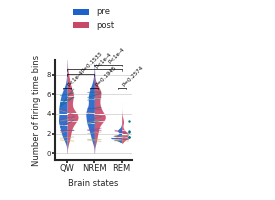

In [9]:
#------------------------------------------------------------------------------------------------------------
# Define functions

# def get_pval_statement(pvalue, sign):
#     if pvalue < 0.0001:
#         pvalue_statement = sign*2    
#     elif pvalue < 0.01:
#         pvalue_statement = sign
#     else:
#         pvalue_statement = 'ns'
#     return pvalue_statement

def get_pval_statement(pvalue):
    if pvalue < 0.0001:
        pvalue_statement = 'P<1e-4'
    else:
        pvalue_statement = f'P={pvalue:.4f}'
    return pvalue_statement

def plot_violin(ax, data, color, xvar, yvar, zvar):
    alpha = 0.9
    order = ['QW', 'NREM', 'REM']
    vio = sns.violinplot(data=data, x = xvar, y = yvar, hue=zvar, split=True, cut=0, inner='quartiles', ax=ax, palette=color, linewidth=0, capstyle='butt')
    for violin, curr_alpha in zip(ax.collections[::1], [alpha] * 6):
        violin.set_alpha(curr_alpha)
    for l in ax.lines:
        l.set_linestyle('-')
        l.set_linewidth(0.5)
        l.set_color('white')
        l.set_alpha(1)
    for l in ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(.75)
        l.set_color('white')
        l.set_alpha(1)
    ax.grid(axis='y', color=(.8,.8,.8), linewidth=0.5)
    for axis in ['left', 'bottom']:
        ax.spines[axis].set_linewidth(1.5)

    # vio.legend(loc="upper center", bbox_to_anchor=(0.5, 1.5))
    vio.set_title("")



#------------------------------------------------------------------------------------------------------------
# Set up colors ans styles

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':1.5,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':8,
    'xtick.labelsize':6,
    'ytick.labelsize':5,
    'legend.fontsize':6,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

colors = [
    '#005CE9', # PRE
    '#DD335D' # # POST
    ] 

dataset_specific_colors = ["#BDA55D", "#046C7C", "#85459B"] # , 

#---------------------------------------------------------------------------------------------------------------
# Create figure and subplots

plotheight = 2
plotwidth = 2.75
font_size = 6

fig = plt.figure()
fig.set_size_inches([plotwidth, plotheight])
gs = GridSpec(nrows=1, ncols=2, figure=fig, hspace=0.3, wspace=0.5)



active_unit_idx = np.where((firing_bin_counts_df['if_active_unit'] == True) & (firing_bin_counts_df['epoch'].isin(['pre', 'post'])))[0]  #  &  (firing_bin_counts_df['brain_state'].isin(['NREM', 'QW']))
firing_bin_counts_df_active_units = firing_bin_counts_df.iloc[active_unit_idx].reset_index(drop=True)


y_variables = ['firing_bin_counts', 'avg_num_cofiring_units']   
y_varialbe_names = ['Number of firing time bins', 'Mean number of cofiring units']
brain_states = ['QW', 'NREM', 'REM']
num_brain_states = len(brain_states)

for y_variable_index, y_variable in enumerate(y_variables):

    ax0 = fig.add_subplot(gs[y_variable_index])
    ax0.set_ylim([-0.05*np.ptp(firing_bin_counts_df[y_variable][~np.isnan(firing_bin_counts_df[y_variable])]), np.nanpercentile(firing_bin_counts_df[y_variable], 99.5)])


    plot_violin(ax0, firing_bin_counts_df_active_units, colors, 'brain_state', y_variable,  'epoch')

    # Drawing the medians for each session
    for brain_state_idx, brain_state in enumerate(brain_states):
        for session_idx, session_name in enumerate(sessions):        
            session_number = included_session_IDX[session_idx]

            current_data = [firing_bin_counts_df_active_units.loc[(firing_bin_counts_df_active_units['session_name'] == session_name) 
                                                                  & (firing_bin_counts_df_active_units['brain_state'] == brain_state) 
                                                                  & (firing_bin_counts_df_active_units['epoch'] == epoch), y_variable].values for epoch in ['pre', 'post']]
            current_data = np.array(current_data)
            current_data = np.transpose(current_data)

            if session_number in range(5):
                color = dataset_specific_colors[0]
            elif session_number in range(6,11):
                color = dataset_specific_colors[1]
            else:
                color = dataset_specific_colors[2]
            
            medians = np.nanmedian(current_data, axis=0)
            if np.all(np.isfinite(medians)):
                ax0.plot([brain_state_idx-0.25, brain_state_idx+0.25], np.nanmedian(current_data, axis=0), linewidth= 0.5, color=color, alpha=0.7) 
            else:
                ax0.scatter(brain_state_idx+0.25, medians[1], s = 0.5, color=color, alpha=1)


        # the data by pooling over units from all recording sessions
        current_data = [firing_bin_counts_df_active_units.loc[(firing_bin_counts_df_active_units['brain_state'] == brain_state) & (firing_bin_counts_df_active_units['epoch'] == epoch), y_variable].values for epoch in ['pre', 'post']]
        current_data = np.array(current_data)
        current_data = np.transpose(current_data)


        unit_indexes_with_valid_values = np.all(np.isfinite(current_data), axis=1)
        current_data = current_data[unit_indexes_with_valid_values]
        _, p_value = wilcoxon(current_data[:,0], current_data[:,1], nan_policy='omit')

        significance_line_y = 0.7*ax0.get_ylim()[1]
        ax0.plot([brain_state_idx-0.15, brain_state_idx+0.15], [significance_line_y, significance_line_y], color = 'black', linewidth=0.5) 
        [ax0.plot([x, x], [significance_line_y*0.98, significance_line_y], color = 'black', linewidth=0.5, alpha=0.8) for x in [brain_state_idx-0.15, brain_state_idx+0.15]]
        
        ax0.annotate(get_pval_statement(p_value), xy = (brain_state_idx, significance_line_y), color = 'black', ha = "left", va="bottom", rotation = 45, fontsize = 4)


    # Test the significant effect of brain states on the y variables
    grouped_data=firing_bin_counts_df_active_units.groupby("brain_state")
    for label, group in grouped_data:
        print(f"Group: {label}")

    grouped_data = [group[y_variable].values for _, group in firing_bin_counts_df_active_units.groupby("brain_state")] # the order is NREM, QW, REM
    grouped_data = np.transpose(np.array(grouped_data))
    grouped_data = grouped_data[:, [1,0,2]] # change the order to QW, NREM, and REM to remian consistent with the rest of the code regarding the order of brain states


    # first using the Friedman chi square test
    not_nan_idx = np.where(~np.isnan(grouped_data).any(axis=1))[0]
    data_array_cln = grouped_data[not_nan_idx]
    statsitic, friedman_p_value = friedmanchisquare(data_array_cln[:, 0], data_array_cln[:, 1], data_array_cln[:, 2])
    # print(friedman_p_value)

    # # Post-hoc analysis using wilcoxon signed-rank to test the differences between each pair of brain states
    
    post_hoc_p_values = np.full((num_brain_states, num_brain_states), np.nan)

    for brain_state_i in range(num_brain_states):
        for brain_state_j in range(brain_state_i+1, num_brain_states):

            _, post_hoc_p_values[brain_state_i, brain_state_j] = wilcoxon(grouped_data[:, brain_state_i], grouped_data[:, brain_state_j], nan_policy='omit')
           
            significance_line_y = (0.8+0.05*(brain_state_i+brain_state_j))*ax0.get_ylim()[1]

            ax0.plot([brain_state_i, brain_state_j], [significance_line_y, significance_line_y], color = 'black', linewidth=0.5) 
            [ax0.plot([x, x], [significance_line_y*0.98, significance_line_y], color = 'black', linewidth=0.5, alpha=0.8) for x in [brain_state_i, brain_state_j]]
           
            ax0.annotate(get_pval_statement(post_hoc_p_values[brain_state_i, brain_state_j]), xy = (np.mean([brain_state_i, brain_state_j]), significance_line_y), color = 'black', ha = "left", va="bottom", rotation = 45,fontsize = 4)


    ax0.set_xlabel("Brain states")
    ax0.set_ylabel(y_varialbe_names[y_variable_index])

    if y_variable_index == 0:
        ax0.legend(loc="upper center", bbox_to_anchor=(0.5, 1.6))
    else:
        ax0.legend("")

    ax0.tick_params(axis='both', which='major', length=2, pad=1)


    plt.subplots_adjust(left=0.2, right= 0.9, bottom=0.2, top=0.7)
    

    filename = 'distribution_of_number_of_firing_bins_pooled.pdf'
    file_path = os.path.join(data_dir, filename)
    plt.savefig(file_path, format='pdf', dpi=300)

